(pennylane)=

# PennyLane

Автор(ы):

- [Ширкин Сергей](https://github.com/SergeiShirkin)


[PennyLane](https://pennylane.ai/) -- библиотека Python для квантового машинного обучения, которую можно использовать для обычных квантовых вычислений. Программы, написанные на PennyLane, можно запускать, используя в качестве бэкенда настоящие квантовые компьютеры от IBM Q, Xanadu, Rigetti и другие, либо квантовые симуляторы.

Кубиты в PennyLane называются по-особому -- `wires` (от англ. wires -- провода). Такое название, скорее всего, связано с тем, что на квантовых схемах кубиты изображаются в виде продольных линий.

Последовательность квантовых операций называется _квантовой функцией_. Такая функция может принимать в качестве аргументов только хэшируемые объекты. В качестве возвращаемого значения выступают величины, связанные с результатами измерения: ожидаемое значение, вероятности состояний или результаты сэмплирования.

Квантовая функция существует не сама по себе, она запускается на определенном устройстве -- симуляторе либо настоящем квантовом компьютере. Такое устройство в PennyLane называется `device`.

## QNode

Квантовые вычисления при использовании PennyLane раскладываются на отдельные узлы, которые называются `QNode`. Для их создания используются квантовые функции совместно с `device`.

Создавать объекты квантовых узлов можно двумя способами: явно либо с помощью декоратора `QNode`.

Рассмотрим первый способ -- явное создание узла.

In [1]:
import pennylane as qml
from pennylane import numpy as np
qml.drawer.use_style("default")

dev = qml.device("default.qubit", shots=1000, wires=2)
def make_entanglement():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=[0, 1])

circuit = qml.QNode(make_entanglement, dev)
circuit()

array([0.509, 0.   , 0.   , 0.491])

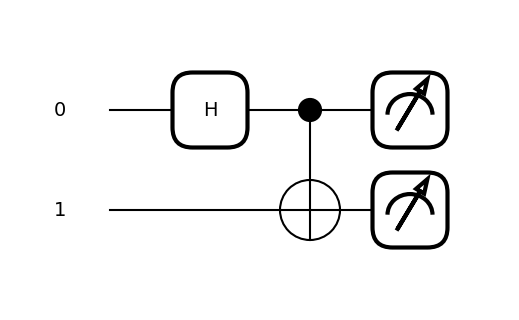

In [2]:
fig, ax = qml.draw_mpl(circuit)()
fig.show()

Работая с библиотекой PennyLane для математических операций, можно использовать интерфейс `NumPy`, но при этом также пользоваться преимуществами автоматического дифференцирования, которое обеспечивает <a href="https://github.com/HIPS/autograd">autograd</a>.
Именно поэтому мы не импортировали `NumPy` обычным способом: `import numpy as np`, а сделали это так: `from pennylane import numpy as np`.

Второй способ создания квантовых узлов -- с помощью декоратора `QNode`. Пропускаем импорт библиотек и создание устройства, так как в начале код тот же самый:

In [3]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=[0, 1])

print(circuit())

[0.506 0.    0.    0.494]


В данном примере мы взяли двухкубитную систему и создали запутанное состояние, а затем с помощью метода `probs` вычислили вероятности получения состояний $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$.

## Операторы

В квантовой функции можно применять операторы X, Y, Z, S, T (`qml.PauliX`, `qml.PauliY`, `qml.PauliZ`, `qml.S`, `qml.T` соответственно), а также операторы, в которых можно задавать угол вращения вокруг одной из осей в радианах: `qml.RX`, `qml.RY`, `qml.RZ`. Здесь и далее будем использовать `qml` как псевдоним библиотеки `PennyLane`.

В этой функции мы вращаем кубит под индексом 0 вокруг оси X на 90 градусов из начального состояния $|0\rangle$ и возвращаем **ожидаемое значение** `qml.PauliZ` для этого кубита с помощью `qml.expval`. Вероятности получения состояний $|0\rangle$ и $|1\rangle$ равны, так что мы получаем ожидаемое значение, близкое к нулю, что легко проверить:

$$0.5 \cdot 1 + 0.5 \cdot (-1) = 0$$

In [4]:
@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    return qml.expval(qml.PauliZ(0))

circuit(np.pi/2)

array(-0.02)

В следующем примере мы вращаем кубит на тот же угол 90 градусов, но уже вокруг оси Y. Ожидаемое значение в этот раз ищем для `qml.PauliX` и получаем 1, что соответствует вычислениям:

$$1 \cdot 1 + 0 \cdot (-1) = 1$$

In [5]:
@qml.qnode(dev)
def circuit(x):
    qml.RY(x, wires=0)
    return qml.expval(qml.PauliX(0))

circuit(np.pi/2)

array(1.)

В начале этого урока мы создали устройство, которое создает и запускает одну и ту же схему 1000 раз, каждый раз производя измерения. Поменяем этот параметр:

In [6]:
dev.shots = 5

Посмотрим на результат каждого из этих пяти запусков и измерений для `qml.PauliZ`. Квантовая схема будет простой: применим к кубиту с индексом 1 оператор Адамара:

In [7]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=1)
    return qml.sample(qml.PauliZ([1]))

circuit()

array([-1, -1,  1,  1,  1])

Мы получаем разные результаты: то 1, что соответствует состоянию $|0\rangle$, то -1, что соответствует состоянию $|1\rangle$.

Если вместо `qml.PauliZ` брать сэмплы для `qml.PauliX`, то результат все время будет один и тот же: 1, что соответствует состоянию $|+\rangle$ (вектор базиса Адамара).

In [8]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=1)
    return qml.sample(qml.PauliX([1]))

circuit()

array([1, 1, 1, 1, 1])

## QubitUnitary

В PennyLane можно использовать готовые операторы, либо задавать операторы явно с помощью матриц.

Для этого можно использовать класс `qml.QubitUnitary`, который принимает два параметра: U -- квадратную унитарную матрицу и `wires` -- кубиты, на которые действует оператор U.

В качестве примера создадим оператор, осуществляющий обмен состояний между кубитами (SWAP). Такой оператор уже есть в библиотеке PennyLane (`qml.SWAP`), но мы создадим его с помощью `qml.QubitUnitary`. Сначала мы зададим саму матрицу в виде двумерного массива, используя интерфейс `NumPy`:

In [9]:
U = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 1]])

Создадим заново устройство, при этом зададим число запусков схемы как `shots=1`: чтобы убедиться, что все работает правильно, нам будет достаточно одного запуска.

In [10]:
dev = qml.device("default.qubit", shots=1, wires=2)

Создадим и запустим схему, в которой перед применением операции SWAP, реализованной с помощью `qml.QubitUnitary`, один кубит будет находиться в состоянии 1, а другой -- в состоянии 0.

In [11]:
@qml.qnode(dev)
def circuit(do_swap):
    qml.PauliX(wires=0)
    if do_swap:
        qml.QubitUnitary(U, wires=[0, 1])
    return qml.sample(qml.PauliZ([0])), qml.sample(qml.PauliZ([1]))

Запустим схему сначала без применения операции SWAP:

In [12]:
circuit(do_swap=False)

(array(-1), array(1))

А затем -- с применением:

In [13]:
circuit(do_swap=True)

(array(1), array(-1))

Видим, что во втором случае операция SWAP сработала: состояния кубитов поменялись местами. Можно посмотреть, как выглядит такая схема:

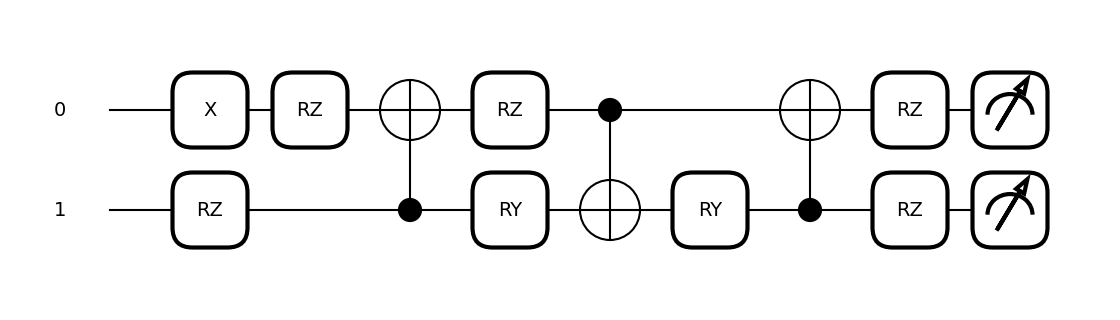

In [14]:
fig, ax = qml.draw_mpl(circuit)(True)
fig.show();